PROJECT OBJECTIVE: Build a sequential NLP classifier which can use input text parameters 
to determine the customer sentiments.

Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import keras
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN
from keras.initializers import Constant
import keras.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import warnings
import string
import re
warnings.filterwarnings('ignore')
sns.set()
import json
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Mounting the Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Read and explore the data

In [3]:
headlines = pd.read_json("/content/drive/My Drive/Colab Notebooks/Sarcasm_Headlines_Dataset.json", lines=True)
headlines.head()



,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
headlines.shape

(26709, 3)

In [5]:
headlines.isnull().sum().sum()

0

In [6]:
headlines.describe(include='object')

,article_link,headline
count,26709,26709
unique,26708,26602
top,https://www.huffingtonpost.comhttp://nymag.com...,the 20 funniest tweets from women this week
freq,2,10


In [7]:
len(headlines[headlines.headline.duplicated()])

107

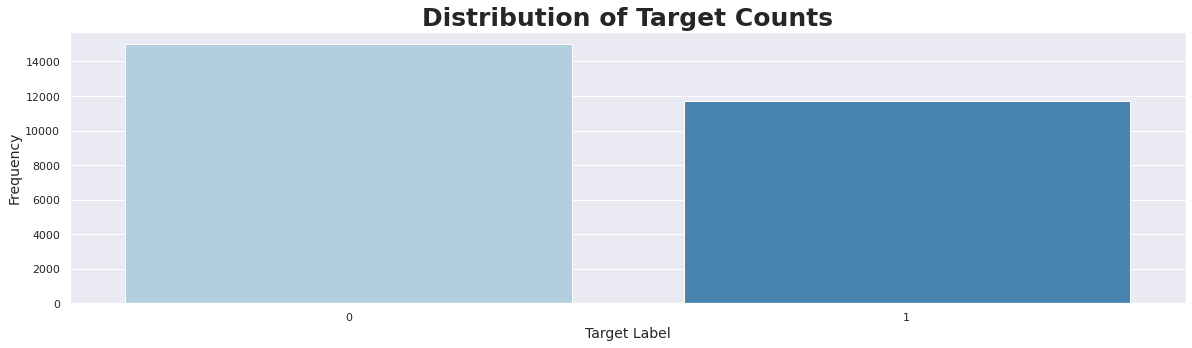

In [8]:
plt.figure(figsize=(20,5))
sns.countplot(headlines.is_sarcastic, palette='Blues')
plt.title("Distribution of Target Counts", size=25, weight='bold')
plt.xlabel("Target Label", size=14)
plt.ylabel("Frequency", size=14)
plt.show()

From the above we can see that, there is an imbalance towards the positive class (sarcastic) in our dataset. This is important as it can have significant effect on the classifier although the imbalance is not severe.

2. Retain relevant columns

In [9]:
headlines.drop('article_link', axis=1, inplace=True)

In [10]:
def clean_headline(headline):
    STOPWORDS = set(stopwords.words("english"))
    headline = headline.lower()
    headline = " ".join(word for word in headline.split() if word not in STOPWORDS)
    headline = "".join(word for word in headline if word not in set(string.punctuation))
    return headline

headlines.headline = headlines.headline.apply(clean_headline)
headlines.head()

,headline,is_sarcastic
0,former versace store clerk sues secret black c...,0
1,roseanne revival catches thorny political mood...,0
2,mom starting fear sons web series closest thin...,1
3,boehner wants wife listen come alternative deb...,1
4,jk rowling wishes snape happy birthday magical...,0


3. Get length of each sentence

In [11]:
headlines['len'] = headlines["headline"].apply (lambda x: len(x.split(" ")))

In [12]:
headlines['len'].head()

0    10
1     8
2     9
3     8
4     8
Name: len, dtype: int64

In [13]:
headlines['len'].describe()

count    26709.000000
mean         7.148377
std          2.289866
min          1.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         27.000000
Name: len, dtype: float64

In [14]:
corpus = []
for text in headlines['headline']:
    words = [word.lower() for word in word_tokenize(text)] 
    corpus.append(words)
num_words = len(corpus)
print(num_words)

26709


Splitting data into train(80%) and test(20%)

In [15]:
X = headlines['headline'].values
y = headlines['is_sarcastic'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [16]:
max_len = 32
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_len, truncating='post', padding='post')

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len, truncating='post', padding='post')

In [17]:
word_index = tokenizer.word_index
print("Number of unique words: {}".format(len(word_index)))

Number of unique words: 25441


In [18]:
embedding = {}
with open("/content/drive/My Drive/glove.twitter.27B.100d.txt") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding[word] = vectors
file.close()

In [19]:
embedding_matrix = np.zeros((num_words, 100))
for i, word in tokenizer.index_word.items():
    if i < (num_words+1):
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [20]:
embedding_matrix.shape

(26709, 100)

Building the Model

In [21]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(21367, 32) (21367,)
(5342, 32) (5342,)


LSTM MODEL

In [22]:
lstm_model = Sequential()

lstm_model.add(Embedding(input_dim=num_words, output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=max_len, trainable=False))
lstm_model.add(LSTM(50, dropout=0.1))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           2670900   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,701,151
Trainable params: 30,251
Non-trainable params: 2,670,900
_________________________________________________________________


In [24]:
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/10
21/21 [==============================] - 23s 268ms/step - loss: 0.6856 - accuracy: 0.5581 - val_loss: 0.6083 - val_accuracy: 0.6752
Epoch 2/10
21/21 [==============================] - 5s 224ms/step - loss: 0.5954 - accuracy: 0.6842 - val_loss: 0.5638 - val_accuracy: 0.7243
Epoch 3/10
21/21 [==============================] - 5s 226ms/step - loss: 0.5479 - accuracy: 0.7296 - val_loss: 0.5282 - val_accuracy: 0.7413
Epoch 4/10
21/21 [==============================] - 5s 226ms/step - loss: 0.5194 - accuracy: 0.7482 - val_loss: 0.5103 - val_accuracy: 0.7535
Epoch 5/10
21/21 [==============================] - 5s 227ms/step - loss: 0.4929 - accuracy: 0.7678 - val_loss: 0.4921 - val_accuracy: 0.7669
Epoch 6/10
21/21 [==============================] - 5s 224ms/step - loss: 0.4654 - accuracy: 0.7858 - val_loss: 0.4726 - val_accuracy: 0.7765
Epoch 7/10
21/21 [==============================] - 5s 229ms/step - loss: 0.4493 - accuracy: 0.7916 - val_loss: 0.4536 - val_accuracy: 0.7911
Epoch

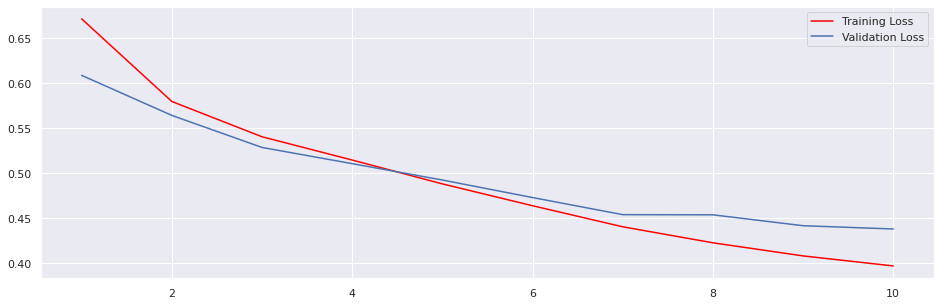

In [25]:
plt.figure(figsize=(16,5))
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['loss'], 'b', label='Training Loss', color='red')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation Loss')
plt.legend()
plt.show()

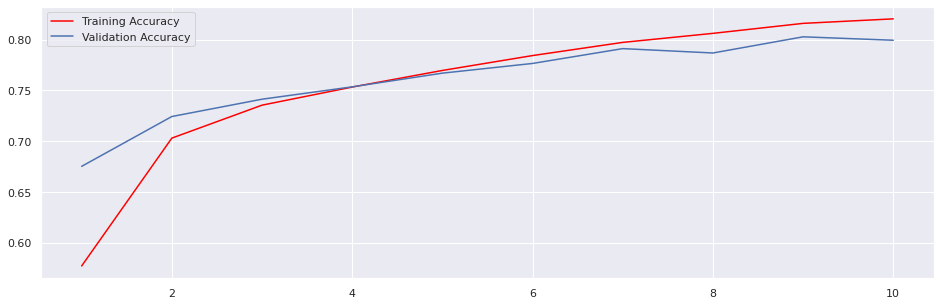

In [26]:
plt.figure(figsize=(16,5))
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy', color='red')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.legend()
plt.show()

In [27]:
print(classification_report(y_test, lstm_model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2996
           1       0.77      0.78      0.77      2346

    accuracy                           0.80      5342
   macro avg       0.80      0.80      0.80      5342
weighted avg       0.80      0.80      0.80      5342



Bi-Directional LSTM

In [28]:
biLSTM = Sequential()

biLSTM.add(Embedding(input_dim=num_words, output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=max_len, trainable=False))
biLSTM.add(Bidirectional(LSTM(units=64, recurrent_dropout = 0.3, dropout = 0.3, 
                             return_sequences = True)))
biLSTM.add(Bidirectional(LSTM(units=32, recurrent_dropout = 0.1, dropout = 0.1)))
biLSTM.add(Dense(1, activation='sigmoid'))

biLSTM.compile(optimizer=keras.optimizers.Adam(lr = 0.01), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
biLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           2670900   
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,796,661
Trainable params: 125,761
Non-trainable params: 2,670,900
_________________________________________________________________


In [31]:
history = biLSTM.fit(X_train, y_train, epochs=10, batch_size=1024, 
                    validation_data=(X_test, y_test))

Epoch 1/10
21/21 [==============================] - 37s 2s/step - loss: 0.3808 - accuracy: 0.8261 - val_loss: 0.4207 - val_accuracy: 0.8006
Epoch 2/10
21/21 [==============================] - 37s 2s/step - loss: 0.3504 - accuracy: 0.8446 - val_loss: 0.4088 - val_accuracy: 0.8111
Epoch 3/10
21/21 [==============================] - 37s 2s/step - loss: 0.3250 - accuracy: 0.8588 - val_loss: 0.4071 - val_accuracy: 0.8139
Epoch 4/10
21/21 [==============================] - 37s 2s/step - loss: 0.3074 - accuracy: 0.8643 - val_loss: 0.4104 - val_accuracy: 0.8252
Epoch 5/10
21/21 [==============================] - 37s 2s/step - loss: 0.2855 - accuracy: 0.8796 - val_loss: 0.4108 - val_accuracy: 0.8255
Epoch 6/10
21/21 [==============================] - 37s 2s/step - loss: 0.2668 - accuracy: 0.8877 - val_loss: 0.4298 - val_accuracy: 0.8190
Epoch 7/10
21/21 [==============================] - 37s 2s/step - loss: 0.2503 - accuracy: 0.8934 - val_loss: 0.4387 - val_accuracy: 0.8250
Epoch 8/10
21/21 [==

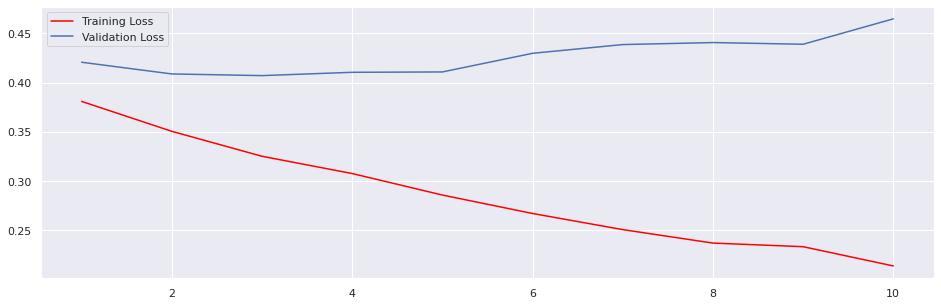

In [32]:
plt.figure(figsize=(16,5))
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['loss'], 'b', label='Training Loss', color='red')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation Loss')
plt.legend()
plt.show()

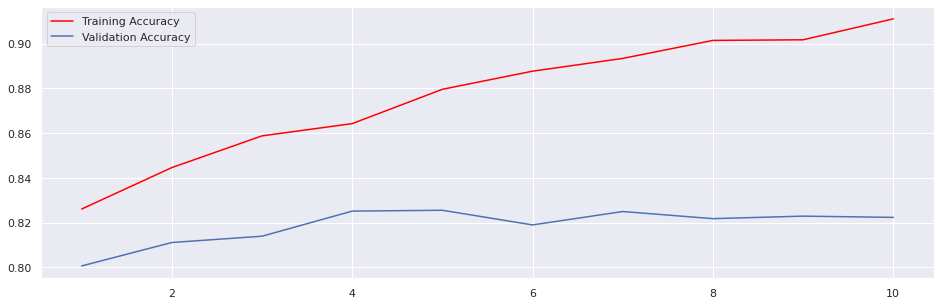

In [33]:
plt.figure(figsize=(16,5))
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy', color='red')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.legend()
plt.show()

In [34]:
print(classification_report(y_test, biLSTM.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      2996
           1       0.82      0.76      0.79      2346

    accuracy                           0.82      5342
   macro avg       0.82      0.82      0.82      5342
weighted avg       0.82      0.82      0.82      5342



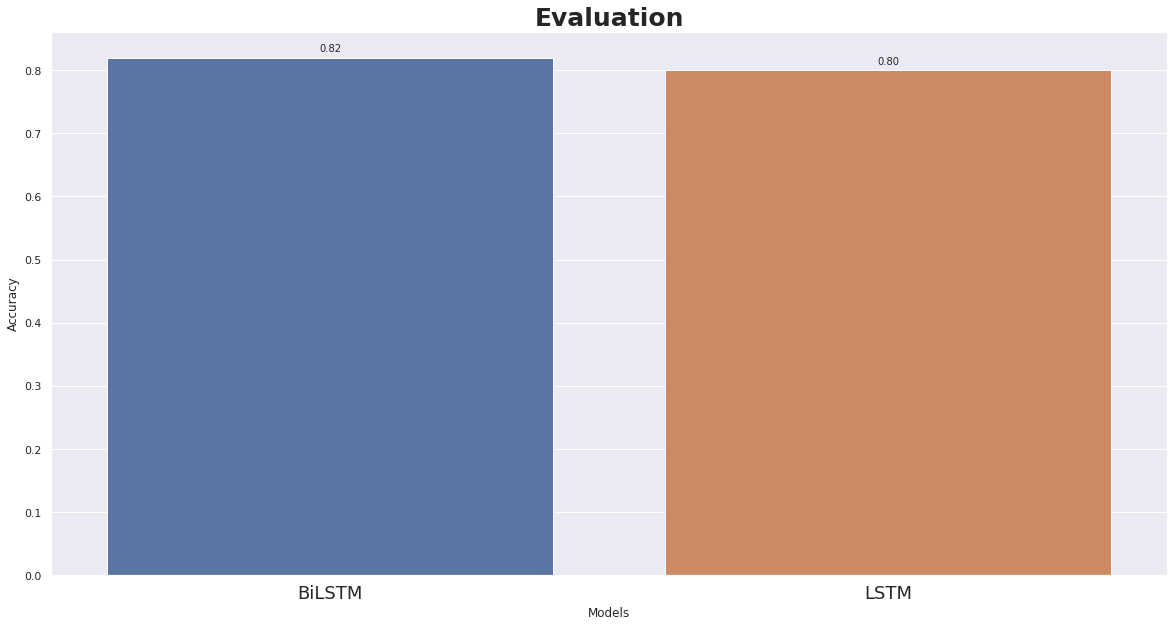

In [35]:
accuracy_lstm = accuracy_score(y_test, lstm_model.predict_classes(X_test))
accuracy_bi_lstm = accuracy_score(y_test, biLSTM.predict_classes(X_test))

conclusion = pd.DataFrame({'Models':['LSTM', 'BiLSTM'], 
              'Accuracy':[accuracy_lstm, accuracy_bi_lstm]})
conclusion['Accuracy'] = conclusion['Accuracy'].apply(lambda x: round(x,2))
conclusion.sort_values(by='Accuracy', inplace = True, ascending = False)

plt.figure(figsize=(20,10))
seaborn_plot = sns.barplot(conclusion.Models,conclusion.Accuracy)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Evaluation", weight='bold', size=25)
plt.xticks(size=18)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

We got a decent accuracy of 82% with some improvement using Bidirectional LSTM model as compared with vanilla LSTM 